In [ ]:
# 從kaggle下載鳥類圖片資料集
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download gpiosenka/100-bird-species/ --unzip


cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Dataset URL: https://www.kaggle.com/datasets/gpiosenka/100-bird-species/versions/
License(s): CC0-1.0
100% 1.95G/1.96G [00:28<00:00, 77.0MB/s]
100% 1.96G/1.96G [00:28<00:00, 74.7MB/s]


In [ ]:
#蹈入必要的函式庫
import tensorflow as tf
import numpy as np
import random
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Activation
from tensorflow.keras import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os


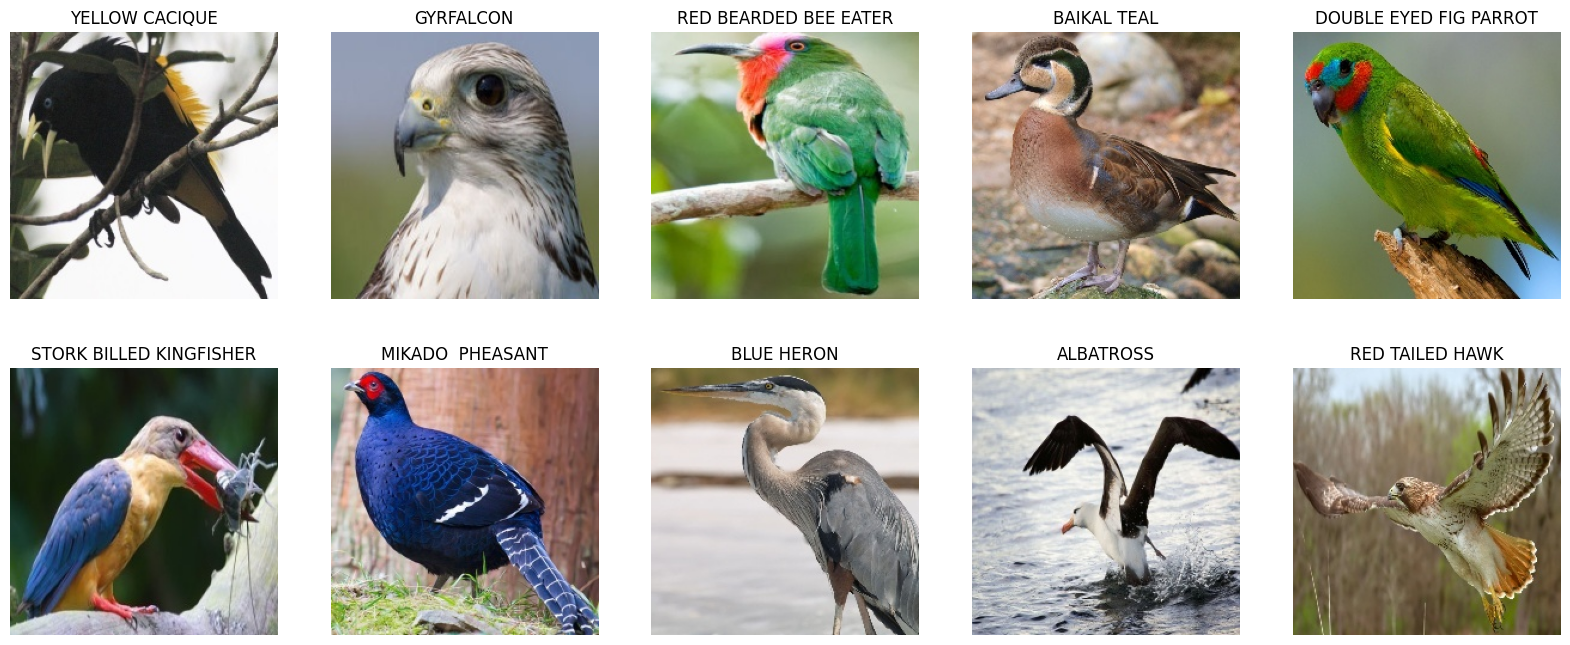

In [ ]:
# 確認圖片
import matplotlib.image as mpimg
def view_random_image(target_dir, target_class):
  # 資料夾位置
  target_folder = target_dir + target_class

  # 隨機圖片
  random_image = random.sample(os.listdir(target_folder), 1)
  # print(random_image)

  # 讀檔顯示圖片
  img = mpimg.imread(target_folder + "/" + random_image[0])
  plt.imshow(img)
  plt.title(target_class)
  plt.axis("off");

  return img

dataset_path = ""

plt.figure(figsize=(20,8))
plt.subplot(2, 5, 1)
bird_img = view_random_image(dataset_path+"train/", "YELLOW CACIQUE")
plt.subplot(2, 5, 2)
bird_img = view_random_image(dataset_path+"train/", "GYRFALCON")
plt.subplot(2, 5, 3)
bird_img = view_random_image(dataset_path+"train/", "RED BEARDED BEE EATER")
plt.subplot(2, 5, 4)
bird_img = view_random_image(dataset_path+"train/", "BAIKAL TEAL")
plt.subplot(2, 5, 5)
bird_img = view_random_image(dataset_path+"train/", "DOUBLE EYED FIG PARROT")
plt.subplot(2, 5, 6)
bird_img = view_random_image(dataset_path+"train/", "STORK BILLED KINGFISHER")
plt.subplot(2, 5, 7)
bird_img = view_random_image(dataset_path+"train/", "MIKADO  PHEASANT")
plt.subplot(2, 5, 8)
bird_img = view_random_image(dataset_path+"train/", "BLUE HERON")
plt.subplot(2, 5, 9)
bird_img = view_random_image(dataset_path+"train/", "ALBATROSS")
plt.subplot(2, 5, 10)
bird_img = view_random_image(dataset_path+"train/", "RED TAILED HAWK")


In [ ]:
# 正規化訓練和測試資料
# 增強訓練數據
def preprocess_and_augment_data(train_dir, test_dir):
  train_datagen_augmented = ImageDataGenerator(rescale=1/255.,
                                             rotation_range=0.2,
                                             zoom_range=0.2,
                                             width_shift_range=0.2,
                                             height_shift_range=0.2,
                                             horizontal_flip=True)

  train_data_augmented = train_datagen_augmented.flow_from_directory(dataset_path+"train/",
                                             target_size=(224, 224),
                                             batch_size=32,
                                             class_mode="categorical",
                                             shuffle=True)
  # Rescale (normalisation)
  test_datagen = ImageDataGenerator(rescale=1/255.)

  test_data = test_datagen.flow_from_directory(test_dir,
                                             target_size=(224, 224),
                                             batch_size=32,
                                             class_mode="categorical",
                                             shuffle=True)
  return train_data_augmented, test_data

train_data_augmented, test_data = preprocess_and_augment_data(train_dir=dataset_path+"train/",
                                        test_dir=dataset_path+"test/")


Found 84635 images belonging to 525 classes.
Found 2625 images belonging to 525 classes.


In [ ]:
#綁定訓練模組
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5"
effecientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"


In [ ]:
import tensorflow_hub as hub
from tensorflow.keras import layers

#定義圖片大小
IMAGE_SHAPE=(224, 224)

# Create models from a URL
def create_model(model_url, num_classes=10):
  """
  Takes a TensorFlow Hub URL and creates a Keras Sequential model with it.

  Args:
    model_url(str): A TensorFlow Hub feature extraction URL.
    num_classes(int): The number of output neurons in the output layer,
    should be equal to a number of target classes, default 10.

  Returns:
    An uncompiled Keras Sequential model with model_url as a feature extractor
    layer and Dense output layer with num_classes output neurons.
  """
  # 下載預訓練模型並儲存為Keras層
  feature_extraction_layer = hub.KerasLayer(model_url,
                                trainable=False, # Freeze the already learned patterns
                                name="feature_extraction_layer",
                                input_shape=IMAGE_SHAPE+(3, ))

  # 創建模型
  model = tf.keras.Sequential([
          feature_extraction_layer,
          layers.Dense(num_classes, activation="softmax",
                       name="output_layer")])

  # 編譯模型
  model.compile(loss="categorical_crossentropy",
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=["accuracy"])

  return model


In [ ]:
# 創建並編譯 Resnet 模型
resnet_model = create_model(resnet_url,
                            num_classes=525)

# 建立並編譯 EfficientNetB0 模型
effecientnet_model = create_model(effecientnet_url,
                            num_classes=525)



In [ ]:
# 建立 TensorBoard 回傳函數
import datetime

def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + \
            datetime.datetime.now().strftime("%Y%m%d-%H")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback


In [ ]:
# 訓練
birds_resnet_history = resnet_model.fit(train_data_augmented,
                                  epochs=5,
                                  steps_per_epoch=len(train_data_augmented),
                                  validation_data=test_data,
                                  validation_steps=len(test_data),
                                  callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                                         experiment_name="resnet50V2")])


Saving TensorBoard log files to: tensorflow_hub/resnet50V2/20240520-16
Epoch 1/5
2645/2645 [==============================] - 1155s 435ms/step - loss: 1.4256 - accuracy: 0.6764 - val_loss: 0.4030 - val_accuracy: 0.8853
Epoch 2/5
2645/2645 [==============================] - 1159s 438ms/step - loss: 0.7272 - accuracy: 0.8139 - val_loss: 0.3668 - val_accuracy: 0.8922
Epoch 3/5
2645/2645 [==============================] - 1149s 434ms/step - loss: 0.6038 - accuracy: 0.8429 - val_loss: 0.3060 - val_accuracy: 0.9120
Epoch 4/5
2645/2645 [==============================] - 1199s 453ms/step - loss: 0.5218 - accuracy: 0.8650 - val_loss: 0.3198 - val_accuracy: 0.9135
Epoch 5/5
2645/2645 [==============================] - 1152s 435ms/step - loss: 0.4851 - accuracy: 0.8732 - val_loss: 0.2816 - val_accuracy: 0.9246


In [ ]:
# 訓練
birds_effecientnet_history = effecientnet_model.fit(train_data_augmented,
                                  epochs=5,
                                  steps_per_epoch=len(train_data_augmented),
                                  validation_data=test_data,
                                  validation_steps=len(test_data),
                                  callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                                         experiment_name="efficientnetB0")])





Saving TensorBoard log files to: tensorflow_hub/efficientnetB0/20240520-18
Epoch 1/5
2645/2645 [==============================] - 1138s 426ms/step - loss: 1.2043 - accuracy: 0.7857 - val_loss: 0.2208 - val_accuracy: 0.9650
Epoch 2/5
2645/2645 [==============================] - 1159s 438ms/step - loss: 0.3742 - accuracy: 0.9132 - val_loss: 0.1441 - val_accuracy: 0.9691
Epoch 3/5
2645/2645 [==============================] - 1113s 421ms/step - loss: 0.2662 - accuracy: 0.9342 - val_loss: 0.1114 - val_accuracy: 0.9707
Epoch 4/5
2645/2645 [==============================] - 1135s 429ms/step - loss: 0.2079 - accuracy: 0.9476 - val_loss: 0.0939 - val_accuracy: 0.9760
Epoch 5/5
2645/2645 [==============================] - 1150s 435ms/step - loss: 0.1709 - accuracy: 0.9560 - val_loss: 0.0911 - val_accuracy: 0.9760


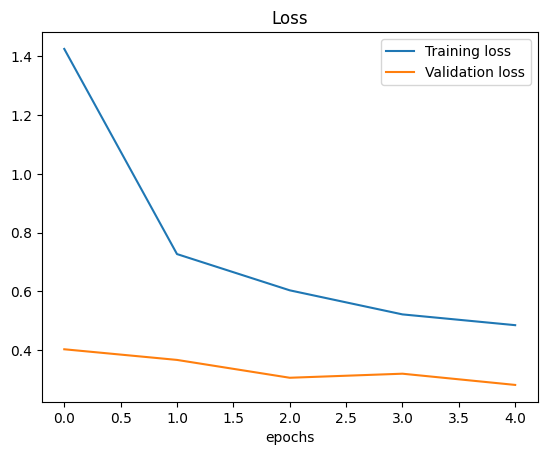

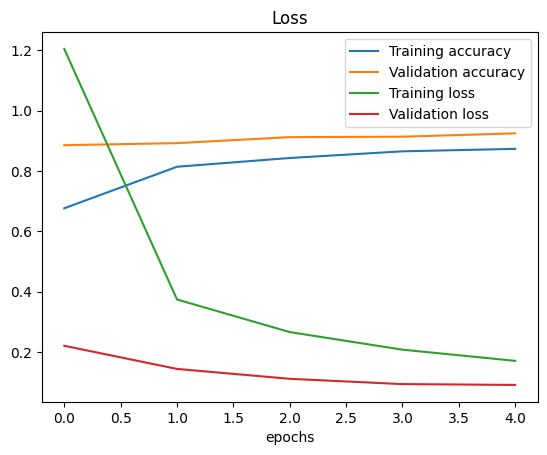

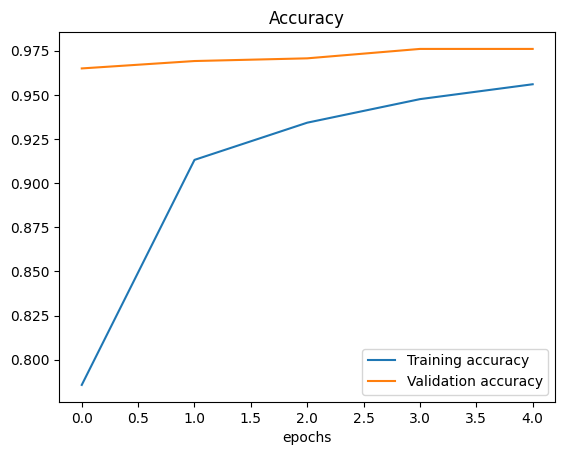

In [ ]:
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation matrix
  """
  loss = history.history["loss"]
  val_loss = history.history["val_loss"]

  accuracy = history.history["accuracy"]
  val_accuracy = history.history["val_accuracy"]

  epochs = range(len(history.history["loss"]))

  # 損失函數
  plt.plot(epochs, loss, label="Training loss")
  plt.plot(epochs, val_loss, label="Validation loss")
  plt.title("Loss")
  plt.xlabel("epochs")
  plt.legend()

  # 準確率
  plt.figure();
  plt.plot(epochs, accuracy, label="Training accuracy")
  plt.plot(epochs, val_accuracy, label="Validation accuracy")
  plt.title("Accuracy")
  plt.xlabel("epochs")
  plt.legend()

# Plot loss curves
plot_loss_curves(birds_resnet_history)
plot_loss_curves(birds_effecientnet_history)


In [ ]:
effecientnet_model.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (  (None, 1280)              4049564   
 KerasLayer)                                                     
                                                                 
 output_layer (Dense)        (None, 525)               672525    
                                                                 
Total params: 4722089 (18.01 MB)
Trainable params: 672525 (2.57 MB)
Non-trainable params: 4049564 (15.45 MB)
_________________________________________________________________


In [ ]:
resnet_model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (  (None, 2048)              23564800  
 KerasLayer)                                                     
                                                                 
 output_layer (Dense)        (None, 525)               1075725   
                                                                 
Total params: 24640525 (94.00 MB)
Trainable params: 1075725 (4.10 MB)
Non-trainable params: 23564800 (89.89 MB)
_________________________________________________________________


In [ ]:
import pathlib
# Get the classnames programatically
def get_classnames(dataset_train_directory=dataset_path+"train/"):
  # Get the classnames programatically
  data_dir = pathlib.Path(dataset_train_directory)
  class_names = np.array(sorted([item.name for item in data_dir.glob("*")]))
  print(class_names)
  return class_names

class_names = get_classnames()

# Prepare an image for prediction
def load_and_prepare_image(filename, img_shape=224):
  """
  Preparing an image for the image prediction task.
  Reads and reshapes the tensor into the needed shape.
  """

  # Read the image
  img = tf.io.read_file(filename)

  # Decode the image into tensorflow
  img = tf.image.decode_image(img)

  # Resize the image
  img = tf.image.resize(img, size = [img_shape, img_shape])

  # Rescale the image
  img = img/255.

  return img

def predict_and_plot(model, filename, class_names, known_label=False):
    """
    Imports an image at the filename, makes the prediction,
    plots the image with the predicted class as the title.
    """

    # import the target image and preprocess it
    img = load_and_prepare_image(filename)

    # Make a prediction
    predicted = model.predict(tf.expand_dims(img, axis=0))

    # Get the predicted class
    # Check for multi-class classification
    print(predicted)
    if len(predicted[0])>1:
      predicted_class = class_names[tf.argmax(predicted[0])]
    else:
      # Binary classification
      predicted_class = class_names[int(tf.round(predicted[0]))]

    # Plot the image and predicted class
    plt.figure(figsize=(5,5))
    plt.imshow(img)
    if known_label:
        if (known_label == predicted_class):
            plt.title(f"Predicted correctly: {predicted_class}")
        else:
            plt.title(f"{known_label } predicted as {predicted_class}")
    else:
        plt.title(f"Predicted: {predicted_class}")
    plt.axis(False)


['ABBOTTS BABBLER' 'ABBOTTS BOOBY' 'ABYSSINIAN GROUND HORNBILL'
 'AFRICAN CROWNED CRANE' 'AFRICAN EMERALD CUCKOO' 'AFRICAN FIREFINCH'
 'AFRICAN OYSTER CATCHER' 'AFRICAN PIED HORNBILL' 'AFRICAN PYGMY GOOSE'
 'ALBATROSS' 'ALBERTS TOWHEE' 'ALEXANDRINE PARAKEET' 'ALPINE CHOUGH'
 'ALTAMIRA YELLOWTHROAT' 'AMERICAN AVOCET' 'AMERICAN BITTERN'
 'AMERICAN COOT' 'AMERICAN DIPPER' 'AMERICAN FLAMINGO'
 'AMERICAN GOLDFINCH' 'AMERICAN KESTREL' 'AMERICAN PIPIT'
 'AMERICAN REDSTART' 'AMERICAN ROBIN' 'AMERICAN WIGEON'
 'AMETHYST WOODSTAR' 'ANDEAN GOOSE' 'ANDEAN LAPWING' 'ANDEAN SISKIN'
 'ANHINGA' 'ANIANIAU' 'ANNAS HUMMINGBIRD' 'ANTBIRD' 'ANTILLEAN EUPHONIA'
 'APAPANE' 'APOSTLEBIRD' 'ARARIPE MANAKIN' 'ASHY STORM PETREL'
 'ASHY THRUSHBIRD' 'ASIAN CRESTED IBIS' 'ASIAN DOLLARD BIRD'
 'ASIAN GREEN BEE EATER' 'ASIAN OPENBILL STORK' 'AUCKLAND SHAQ'
 'AUSTRAL CANASTERO' 'AUSTRALASIAN FIGBIRD' 'AVADAVAT' 'AZARAS SPINETAIL'
 'AZURE BREASTED PITTA' 'AZURE JAY' 'AZURE TANAGER' 'AZURE TIT'
 'BAIKAL TEAL' 'BALD EAGLE

1/1 [==============================] - 0s 490ms/step
[[3.50979020e-17 4.96651433e-14 1.26598380e-17 1.29623384e-16
  3.73662825e-14 1.33647759e-13 1.19775493e-24 1.17092522e-15
  4.81005288e-16 5.77268153e-19 3.67059428e-22 8.21788106e-20
  5.37522450e-22 6.53977537e-14 4.12236013e-17 3.70645051e-12
  1.54328570e-22 9.28434176e-20 6.22922164e-19 3.69334158e-18
  6.25497451e-15 7.12537412e-19 2.20788018e-16 2.64071336e-16
  2.90898576e-17 3.58679331e-16 1.04468162e-22 1.20050237e-12
  1.86323136e-18 2.14796944e-13 3.33145569e-17 6.16278197e-19
  4.06699448e-14 2.39796668e-16 1.39365044e-17 2.49440010e-19
  8.66742642e-15 5.96502118e-19 2.19730636e-12 1.58590456e-21
  4.13924300e-14 3.00147581e-17 4.88031359e-20 2.46486750e-13
  4.27700711e-16 2.31089258e-12 1.07689335e-12 5.61899356e-17
  2.81661969e-14 1.12771733e-17 1.09617511e-22 5.99605152e-18
  1.13845695e-12 2.25387007e-21 6.70143346e-20 1.41844071e-17
  4.12802751e-16 6.47415593e-11 1.38853105e-15 2.45969460e-11
  9.99999285e-01 

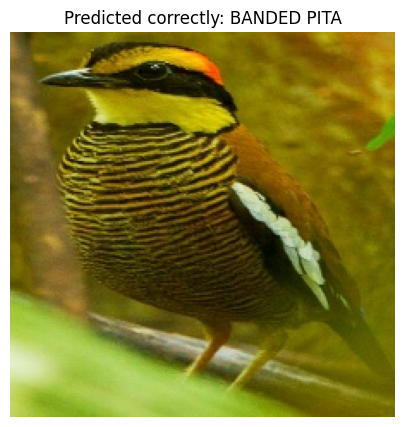

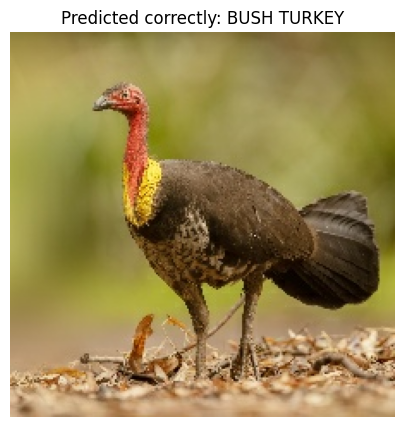

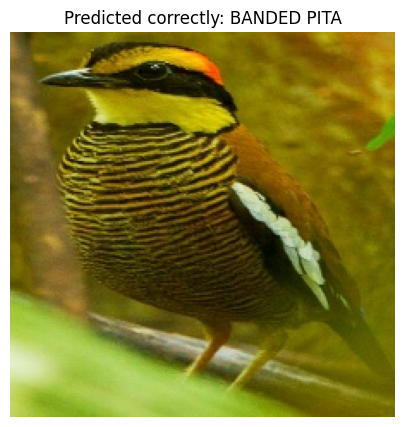

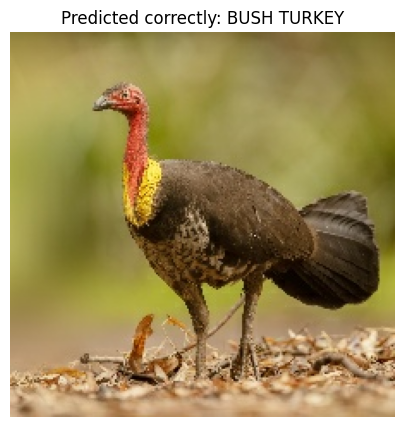

In [ ]:
# Let's try to predict again with ResNet
predict_and_plot(resnet_model,
                 filename=dataset_path+"test/BANDED PITA/3.jpg",
                 class_names=class_names, known_label="BANDED PITA")
predict_and_plot(resnet_model,
                 filename=dataset_path+"test/BUSH TURKEY/2.jpg",
                 class_names=class_names, known_label="BUSH TURKEY")
# Let's try to predict again with EffecientNet
predict_and_plot(effecientnet_model,
                 filename=dataset_path+"test/BANDED PITA/3.jpg",
                 class_names=class_names, known_label="BANDED PITA")
predict_and_plot(effecientnet_model,
                 filename=dataset_path+"test/BUSH TURKEY/2.jpg",
                 class_names=class_names, known_label="BUSH TURKEY")
